# Assessment for Advanced Data Science

## Christian Cabrera, Radzim Sendyka, Carl Henrik Ek and Neil D. Lawrence

### 6th November 2023



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code.

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total. At the end, we would like to know your experience using LLMs in this assignment.

### Important Note:

*Some tasks in this assignment require you to develop skills for searching for multiple solutions and trying different things. This environment recreates industrial data science and software engineering problems. There is no one right answer.*


### README - Kornel Szabo [IMPORTANT]

I tried using the Fynesse framework in the following way:
- Access: accessing the data
- Assess: Looking at the dataset without a question in mind, and later building intuition for the key parts of the problem
- Addresss: Using the intuition from the assess stage to take different approaches to takling the problem

For any code that is not necessarily exposed, I abstracted them away into the appropriate file, trying to make it as reusable as possible.  

For the code that is not specific to the current project, I created an utils directory, where I separated the code by the type of helper function it is.

The unit tests kept breaking on GitHub, so instead of that approach, I tried making internal sanity checks in the code, e.g. `fynesse/utils/pandas_utils.py:aligned_concat`, where the code would raise errors for malfunctioning.

I also tried plotting/sampling the data at various points throughout the project as a sanity check to make sure we are working with the right things.

### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

UK Price Paid Data explainer:
https://www.gov.uk/guidance/about-the-price-paid-data

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below.



In [1]:
!pip install -r ../requirements.txt -q

In [2]:
%pip install git+https://github.com/xt0r3-Cambridge/ads_fynesse_repo.git --no-cache-dir --force-reinstall -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.32.5 requires urllib3<1.27,>=1.25.4; python_version < "3.10", but you have urllib3 2.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from fynesse import access, address, assess
from fynesse.assess import *
from fynesse.utils.io_utils import get_or_load, load, save
from fynesse.utils.pandas_utils import aligned_concat
from fynesse.utils.plotting_utils import bin_plot, subplots_iter
from fynesse.utils.stats_utils import male, standardise
from fynesse.utils.type_utils import coerce_args

In [5]:
import pickle
from datetime import datetime
from decimal import Decimal
from pathlib import Path

import folium
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yaml
from folium import plugins
from geopy.geocoders import Nominatim
from ipywidgets import Password, Text, interact_manual
from matplotlib import pyplot as plt
from osmnx._errors import InsufficientResponseError
from plotly import express as px
from shapely import Point
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from tqdm import tqdm

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*.

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

Important Notes:

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (31st October 2023). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*We recommend doing Question 1 as early as possible to avoid being blocked from important work given that uploading the data can take long.*

*If you encounter problems with the online notebook (e.g., interrupted connections with the AWS server), you can use a local IDE to work in your machine.*

*5 Marks*

### Licenses

In [6]:
print(access.legal())

Contains HM Land Registry data © Crown copyright and database right 2021. 
This data is licensed under the Open Government Licence v3.0.

Contains OS data © Crown copyright and database right 2023
Contains Royal Mail data © Royal Mail copyright and database right 2023
Contains GeoPlace data © Local Government Information House Limited copyright and database right 2023
Source: Office for National Statistics licensed under the Open Government Licence v.3.0



### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.
  
Call the database you use for this assessment `property_prices`.
  

In [7]:
if not Path("credentials.yaml").exists():

    @interact_manual(
        username=Text(description="Username:"),
        password=Password(description="Password:"),
    )
    def write_credentials(username, password):
        with open("credentials.yaml", "w") as file:
            credentials_dict = {"username": username, "password": password}
            yaml.dump(credentials_dict, file)

In [8]:
with open("credentials.yaml") as file:
    credentials = yaml.safe_load(file)

db = access.GlobalDatabaseManager(
    username=credentials["username"],
    password=credentials["password"],
)

loader = access.DatasetLoader(db)

In [9]:
loader.create_main_table()

In [10]:
assert False

AssertionError: 

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using


```
LOAD DATA LOCAL INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module.

Each 'data part' should be downloadable from the `gov.uk` site. It should take around 5 minutes to download the whole dataset. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in around 15 minutes. You should get a table with 28'258,161 rows. ***Note: A select count of the table can take more than half an hour.***

You may find the following schema useful in the creation of your table:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key to the `pp_data` table. This should be done before uploading your data.

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `pp_data`
MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

```GIVE YOUR WRITTEN ANSWER HERE```


It gives the types of different columns of the database.  
E.g. `varchar(8) COLLATE utf8_bin NOT NULL,` means an `utf_8` encoded character sequence of length at most 8 without missing values.
`AUTO_INCREMENT` sets up automatic increases for the primary key.  
The first entries in the rows (e.g. `transaction`) are the names of the columns in the dataframe.  
`DROP TABLE IF EXISTS` deletes the table if it already exists to make sure that we have consistency in case we change the data we want to upload to it.

In [ ]:
loader.process_prices()

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use. Downloading and unzipping the data should not take more than 10 seconds.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up a primary key for the new table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

And you can load the CSV file into the table using this command.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```

In [ ]:
loader.process_postcodes()

### Task D  


This table should contain the house price paid and the latitude and longitude of the house. We could create a new data frame that contains all this information. However, the computation of that data frame would take some time because of the size of the two existing tables in the join. Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would be better to store the join as a new table in the database, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better.

- Option A: Think about which columns from each table will be useful to you in making predictions, then write code to efficiently select this information and create a data frame from the two tables for a set of properties. "Join on the fly". This option looks easier but the disadvantage is the extra latency it adds as joins are performed every time we need to answer data questions. These latencies are usually not accepted in production environments.

- Option B: Alternatively, you can create a database table called `property_prices` to store the join of the tables you created in the previous tasks. The advantage of this approach is that you will get faster responses because the join is performed once. The disadvantage is that populating the new table can take a long time because you would join two big tables. You need to be more creative with this option. Remember that you can divide your dataset by different criteria (e.g., by year) and that loading data from files is much faster than `INSERT INTO` instructions. Populating the table took from 4 to 6 minutes per year in our tests on a Dell Laptop Intel Core i5 with 16GB of RAM and using the Eduroam network at the Computer Lab. Populating the table by year also gives you control over the upload process. You could write your code in a way you can stop and restart the upload process. The new table could have a schema like the one below:

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```

In both cases you will need to perform a join between `pp_data` and `postcode_data` tables. Joining large tables without the right indexes in place will take a long time. You should think and set the right index for an efficient join. Indexing the `pp_data` table should take less than 5 minutes, while it takes less than one minute to index the `postcode_data` table.

Note that there is no preference for either approach in the mark scheme.

You should use the joined data in your prediction model in Question 3. Exploit the nature of the task to use prices for a particular region in a given period. This means we can select the relevant rows from the database according to that region and period.

***After you have populated your database tables and created the functions to access the data you need for Question 3, you will not need to redo any of the previous steps. If at some point you find the AWS database is not responding or taking longer than expected to perform operations, you can have a look at the process list and kill the one are causing problems. If killing the processes does not work, you should reboot the database in the AWS console. Be careful with other database instances if you need to reboot your database. Also, be careful not to delete the database instead of rebooting it. If you delete the database, it is likely you will need to redo all Question 1.***

In [ ]:
loader.create_merged_table()

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below.

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


### Sample of the Data

- Motivation:
    - Familiarising ourselves with the data
- Observation:
    - Locality is empty forthe sample below - possibly an issue with null values
- Conclusion:
    - We should investigate how much data is empty

In [ ]:
sample = pd.DataFrame(db.query(limit=1, as_pandas=False))
sample

### Null values

- Motivation:
    - Find any data that is missing
- Observation:
    - There are no null values in the data
    - There are **many** empty values for locality
    - The empty values for the other fields seem to all occur within 2 properties.
- Conclusion:
    - When querying the data, we should treat empty values as NaN
    - We shouldn't rely on `locality` as a feature, as it's mostly NaN
    - The other fields are fine without any processing

In [ ]:
null_counts = assess.get_null_counts(db)
null_counts

In [ ]:
db.query(where="TRIM(`new_build_flag`) = ''")

### Dates

- Motivation:
    - House purchases may exhibit seasonality or some other temporal patterns
- Observation:
    - The number of transactions is dominated by macroeconomical events (e.g. COVID), making conclusions hard
    - If we residualise autocorrelation by looking at the difference of the `30-day` and `120-day` mean transaction counts, we can notice seasonality consistent with [existing literature](https://www.investopedia.com/articles/investing/010717/seasons-impact-real-estate-more-you-think.asp) (the areas in green are peak home-sale seasons).
- Conclusion:
    - We could use the month as an adjustment of the prices based on increased demand.

In [ ]:
assess.plot_tx_count_over_time(db)

### Price Outliers

- Motivation:
    - It would be good to know how much of the data is unreasonably high, because if there are relatively few outliers, we can just get rid of them.
- Observation:
    - There are a few **extreme** outliers in the high-price regions, but there seem to be quite a few properties worth multiple millions.
    - There are also a lot of very cheap houses, the 10000-th lowest price is still below `10000`.
- Conclusions:
    - Instead of dropping outliers, it seems better to try to understand why they exist and how we can work with them.

In [ ]:
assess.plot_outliers(db)

### Subsampling the data

- Motivation:
    - Pandas is more flexible than SQL, allowing for rapid iteration.
- Observation:
    - London seems to dominate other places by transaction count
        - This means that if something is bad in London, it will be bad on the dataset as a whole
- Conclusion:
    - We will try predicting prices in London first, and we will only extend models that work well in London to the entire dataset.

In [ ]:
ldn_px = assess.load_place_prices("London", db)
ldn_amenities = assess.load_place_tags("London", tags={"amenity": True})
cbg_px = assess.load_place_prices("Cambridge", db)
cbg_amenities = assess.load_place_tags("Cambridge", tags={"amenity": True})
ips_px = assess.load_place_prices("Ipswich", db)
ips_amenities = assess.load_place_tags("Ipswich", tags={"amenity": True})

### Plotting Log Property Prices

- Motivation:
    - Before even knowing the question, playing aronud with the dataset can be highly beneficial. To get some undestanding of the localities of the data, we plot some data over the neighbourhoods and see if there is anthing interesting we notice.
- Observation:
    - It seems that some areas (like E1 7QR) have extremely expensive buildings (hundreds of millions of pounds). There cannot be many such buildings in the country, so it might be wise to try to somehow prune them from the dataset.
    - It seems that London is not the only place with expensive houses: Cambridge has several buildings on the scale of $10^{7.5}$ GBP or more
    - Ipswitch on the other hand, seems fairly normal, with the most expensive houses costing a few millions at most.
    - Apart from the outliers, there seems to be strong spatial locality, with many prices being in the same range (this shows very well on the E1 7QR diagram at houses around $10^6$ GBP being adjacent.
- Conclusion: 
    - Focusing on finding the culprits for the hundred-million buildings should be the top priority.
    - Once we can do that, we can try exploiting the spatial locality in the dataset

In [ ]:
assess.plot_log_prices_around(
    ldn_px[ldn_px.postcode == "E1 7QR"].iloc[0:1],
    world=ldn_px,
)

In [ ]:
assess.plot_log_prices_around(ldn_px.sample(9, random_state=123123), world=ldn_px)

In [ ]:
assess.plot_log_prices_around(cbg_px.sample(9, random_state=19381), world=cbg_px)

In [ ]:
assess.plot_log_prices_around(ips_px.sample(9, random_state=75921), world=ips_px)

### Distribution of Prices vs Property Type

- Motivation:
    - Looking at price distributions within a given category of building can shed some light on specific clusters or subcategories that are more closely related. Identifying those would be very helpful.
    - As with the prices of many assets, the movements are usually based on a percentage change relative to the current price. This percentage has some noise in most models. If we want the noise to be additive for the Central Limit Theorem to hold, we are better off taking the log prices.
    - Thus, we will be observing the log prices and we expect normal of prices.
- Observation:
    - Our model is wrong.
    - The **log prices** are clustered and appear normal with a fat positive tail for detached houses, semi-detached houses and terraced houses.
        - An idea could be to look at the prices per square foot for all of these and see how those are distributed.
        - These prices are still not normally distributed for semi-detached and detached houses, so sadly this approach wasn't too useful.
        - Terraced houses started having two clusters for price per $m^2$. This is interesting, and we will get back to it later.
    - Other seems to have multiple different clusters of houses
        - An explanation of this is that this is expected. The categories in Other include properties such as
            - Hotels, which are really expensive and storage spaces that are very cheap
- Conclusions:
    - Prices per square feet didn't make the distributions normal
    - The log prices are not normally distributed as expected, because the right tails are very fat.
    - Due to the fat right tails, we can't just "get rid" of the outliers. They seem to be an integral part of the distribution.
    - Other is very strange and should be thoroughly investigated.

In [ ]:
assess.plot_log_prices_per_property_type(world=ldn_px)

In [ ]:
assess.plot_log_prices_per_sq_m_per_property_type(world=ldn_px)

### Leaseholds

- Motivation:
    - Some properties in the data are "freeholds" and some are "leaseholds". Without knowing what these terms mean, one could think that leaseholds are supposed to be cheaper, as you get less rights, which seems true at first glance, but is misleading, as seen later.
    - An alternative idea I had was that the leaseholds are mostly commercial buildings
- Observations:
    - Looking up some leaseholds on a map showed that many leaseholds were regular flats. It seems that I was wrong.
    - Looking at the number of leaseholds vs freeholds it seems that flats are mostly leased whereas everything else is mostly sold for freehold.
    - If we check [this](https://www.rightmove.co.uk/house-prices/details/england-59027515-17190829?s=9ca5d04cd6a0ae32london_$1london_$1df804fd7367118f2d4aa869cdec770ac2651a0553e6d7ee#/) listing, we can find some flats that are offered for leaseholds.
    - Checking [this](https://www.propertymark.co.uk/professional-standards/consumer-guides/buying-selling-houses/buying-leasehold-property.html) guide on leaseholds vs freeholds, we find that most flats are offered on lease, because the owner of the larger building wants to still be an owner of the building block.
        - The data is consistent with this assumption - it is mostly flats that are leased and family homes are usually freehold.
- Conclusions:
    - There is no pattern here, it's just that the UK housing market happens to lease flats instead of selling them.

<div hidden>
    
</div>

In [ ]:
assess.count_freeholds_and_leaseholds(world=ldn_px)

### Propety Type: Other

- Motivation:
    - As seen above, other is a weird property type. We try exploring its effects on the dataset and any patterns it might have.
- Observation: 
    - A property of type Other was sold for GBP 20000 in 2020 in Tower Hamlet $-$ this is unbelievable
    - Some properties are in the ranges of 10s of millions
    - If we plot the distributions of log prices with and without other datatypes, we see that the distribution is almost normal with some skew and outliers. These suspiciously cheap outliers tend to be the "Other" properties
    - I think that the unusual properties (e.g. hotels and storage spaces) all belong to other, leading to very high variance.
    - About 30% of the Other data in London seems to be the low-price outliers and the rest seem to be normal.
- Conclusion:
    - We should treat "Other" as a completely separate category from all other prices and create separate prediction models for it.
    - Word of caution: Some other properties seem to actually be sensible, so there **might** be something that we can predict even in this category.
    


In [ ]:
assess.plot_other_infos(world=ldn_px)

All of the outliers below seem to be from Other.  
If we look these buildings up on a map, we find actual buildings. A reasonable explanation could be that these are small storage spaces in existing buildings.

In [ ]:
thousand_dollar_properties = ldn_px.query("price == 1000 & year == '2018'")
thousand_dollar_properties[["price", "date", "property_type"]]

In [ ]:
assess.plot_polygons_on_map(
    thousand_dollar_properties.to_crs(crs=4326).iloc[[0]], zoom_start=19
)

### Property Type: Other - Separating expensive from cheap

- Motivation:
    - If we assume that the expensive buildings in Other are some specific buildings (e.g. hotels) and the cheap ones are storage spaces, then maybe the building type on OpenStreetMaps would be informative regarding the price.
- Observation:
    - Every building type seems to behave strangely unless it only has a handful of buildings in it.
- Conclusion:
    - Negative result, this idea is abandoned.

In [ ]:
assess.plot_other_price_data(world=ldn_px)

### Median House Price Over Time

- Motivation:
    - Inflation would make our old house prices outdated, so any model trained on them would be outdated. It is intersting to see if there is actually an observable change in property prices over time.
- Observation:
    - The median house price has a positive drift over time, showing signs of inflation.
    - The trajectory seems similar for all categories of properties.
- Conclusion: We should adjust for inflation.

(Aside: we don't give a wrapper function for this, as the functions below are very simple)

In [ ]:
dfx = ldn_px.groupby(["quarter"]).price.median()
px.line(dfx, title="Median property price over time")

In [ ]:
dfx = ldn_px.groupby(["quarter", "property_type"]).price.median().unstack()
px.line(dfx, title="Median property price over time per property type")

### Density of Purchases Over Time

- Motivation:
    - We are being very London centric. Maybe there are other points in the UK that are worth exploring.
- Observation:
    - It seems that most purchases occur in one of the following places:
        - London, Manchester, Liverpool, Birmingham, Leeds
- Conclusion:
    - If we find a strategy that works well in London, we could try testing it in these places specifically, in addition to testing on the entire dataset.

In [ ]:
assess.plot_transactions(db)

### Price Clusters

- Motivation:
    - We have seen informal indications of spatial locality of prices. Maybe trying to formalise that using some clustering algorithm would be helpful.
- Observation:
    - Clustering by area doesn't seem to be very helpful, nearby buildings are often put into different clusters.
        - A measure of how well-aligned the nearby buildings are is looking at the number of pairs that have similar postcodes that are in the same clusters compared to the total number of pairs with similar postcodes. (This is the Fleiss kappa measure. In MLRD we were told that this is usually above 0.8 when there is good agreement in the clustering. Ours is 0.04 at most, which seems very bad)
    - Even adjusting for information, we don't see any improvement in the clustering.
- Conclusion:
    - Negative result, the idea was abandoned.

#### Raw Prices

In [ ]:
assess.get_k_means_metrics_raw(world=ldn_px)

#### Adjusting for Inflation

- An idea could be that we are not getting many pairs because the house prices move with inflation, and house prices in 2018 are more likely to be in a group with other house prices in 2018 rather than house prices in the same neighbourhood in 2022.
- Result: attempting to adjust house prices to the last quarterly price seems to make the groupings strictly worse than they were across all cases.

In [ ]:
assess.get_k_means_metrics_inflation_adjusted(world=ldn_px)

### House Price per Town

- Motivation:
    - Getting a mental image of how house prices are distributed across the country could be useful.
    - Therefore, we plot the median house price per area on an UK map, to get some more intuition.
- Observations:
    - Prices are higher in the south
    - Prices are very high around London
    - The sales are quite fragmented. It is perfectly possible to assume that we will need to price a property where we won't have any other sales nearby and we have little data to rely on.
- Conclusion:
    - We should try to build a fallback model that predicts without any nearby buildings.
    - If the prices are higher in the south, then the latitude might be a predictor of price. This should be tested.

In [11]:
price_per_town = assess.get_house_prices_per_town(db)
towns = assess.get_town_outlines(price_per_town)
assess.plot_choropleth(towns=towns, price_per_town=price_per_town)

KeyboardInterrupt: 

### Area

- Motivation:
    - Bigger houses should be more expensive. We expect this to work for non-shared houses (terraced houses, detached houses and semi-detached houses)
    - We don't expect this to work for flats and other, as there we often subletting a part of a larger building
- Observation:
    - For semi-detached and detached houses, there is a positive correlation, as expected
    - For terraced houses, there is a slight negative correlation
        - This is due to the OSMNX data being incorrect. On the figures below, you can see a multiple terraced houses on Google Maps, and you can see how the OSMNX data treats it as one polygon. This is incorrect, according to their own [labelling rules](https://wiki.openstreetmap.org/wiki/Tag:house=terraced), but such is data science.
            - 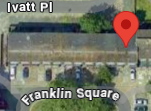
            - 
- Conclusion:
    - Plot area could be a good feature for predicting detached and semi-detached house prices.

#### Semi-detached and Detached houses

The correlation is positive (6%), as expected.

In [ ]:
assess.get_price_and_plot_area_correlation(data=ldn_px, property_types=["S", "D"])

#### Terraced Houses

- We see a slight negative correlation (1%) here. This is the case, as the terraced houses are sometimes labelled as individual units, as they should be according to [OSMNX](https://wiki.openstreetmap.org/wiki/Tag:house=terraced) rules, but sometimes they cover the entire unit, as in the example below. For proof that these are multiple terraces, refer to the image below.



In [ ]:
assess.get_price_and_plot_area_correlation(data=ldn_px, property_types=["T"])

In [ ]:
franklin_sq = ldn_px.query("postcode == 'W14 9UU'").iloc[[0]]
assess.plot_polygons_on_map(
    franklin_sq, franklin_sq.latitude.iloc[0], franklin_sq.longitude.iloc[0], 19
)

### House Price vs Nearby Transactions

- Motivation:
    - The types of buildings sold around a property could convey some information about its location. It could perhaps be in an industrial area, or in the suburbs, both of which have an impact on price.
    - We will use OpenStreetMaps to get building information. To simplify matters, we will simply count the number of different kinds of buildings in a given area and see how that compares to the median price for a given property type in the area.
    - Note that this is **not the same** as looking at all buildings around the area. This is looking at the **transactions**, to give us some insight into how transaction patterns influence median price.
- Observations:
    - When applying PCA, we can notice that the features are not too dependent on each other, no single feature explains all the variance.
    - The first 3 components of the PCA seem to be sensible, building proxies for population density, industrialness and suburbanness.
- Conclusion:
    - We could try using this proxy as a feature in one of our models.

#### Getting Data

In [ ]:
prices_with_building_cnts = assess.get_prices_with_building_cnts(
    world=ldn_px, property_type="F"
)

prices_with_building_cnts

In [ ]:
assess.plot_heatmap(prices_with_building_cnts.corr()).set_title(
    "#Buildings + Price correlation"
)

#### Testing Top Predictors

- Looking at the heatmap of the components below, we can make a few observations
    - The first component seems to simply be a proxy for how central the area is 
        - Commercial buildings, apartments, retail areas, schools are positive
    - The second component is hard to interpret
    - The third component seems to be how urban the area is
        - Offices, flats are important, but terraces, houses, detached houses, etc are not.
    - The fourth component seems to be how suburban/quiet the area is
        - Detached houses, houses, semi-detached houses and terraces seem important here, and nothing else
    - The following features seem to be less interpretable

In [ ]:
pca_weights = assess.apply_pca(prices_with_building_cnts.drop(columns=["price"]))
assess.plot_heatmap(pca_weights).set_title("Principal Components of Building Counts")

### House Price vs Amenities

- Motivation:
    - The amenities surrounding a building (e.g. grocery stores, public transport, universities, etc.) could increase the price of a building
- Observation:
    - Some features are heavily correlated and there are a lot of them. We must apply dimensionality reduction.
    - Unlike the building data, the PCA components are hard to interpret.
- Conclusion:
    - We stick to the counts of the surrounding buildings instead of amenity counts, as we have a better intuitive understanding of its effects on prices.
    - We had too many features to handle here. We should try hand-picking a subset based on intuition rather than hoping that we can get dimensionality reduction to work better.

#### Getting Data

In [ ]:
amenity_cnt = assess.get_tags_per_district(
    "London",
    db,
    tags={"amenity": True},
    threshold=0,
    suffix_length=2,
)
building_cnt = assess.get_tags_per_district(
    "London",
    db,
    tags={"building": True},
    threshold=0,
    suffix_length=2,
)

In [ ]:
cnts = aligned_concat(building_cnt, amenity_cnt)[
    [
        ("building", "school"),
        ("building", "office"),
        ("building", "construction"),
        ("building", "commercial"),
        ("building", "industrial"),
        ("building", "sports_centre"),
        ("building", "residential"),
        ("building", "apartments"),
        ("building", "detached"),
        ("building", "semidetached_house"),
        ("building", "house"),
        ("building", "terrace"),
        ("building", "university"),
        ("building", "retail"),
        ("building", "church"),
        ("building", "government"),
        ("building", "transportation"),
        ("building", "museum"),
        ("amenity", "research_institute"),
        ("amenity", "college"),
        ("amenity", "casino"),
        ("amenity", "hospital"),
        ("amenity", "theatre"),
        ("amenity", "bank"),
        ("amenity", "waste_disposal"),
    ]
]
cnts

#### Plotting Correlations

- Note that there are many highly-correlated features

In [ ]:
assess.plot_heatmap(cnts.corr(), figsize=(30, 30)).set_title("#amenities correlation")

#### Dimensinality Reduction

- The components are a lot less meaningful than with the buildings. The first one seems to be a proxy for how densely populated the area is, but the second noe seems a bit random
    - Example: parking has a negative coefficient, motorcycle parking has a positive one, telephone also seems very positive, and there is just no strong link that I can see that would let me understand what is happening here.

In [ ]:
pca_weights = assess.apply_pca(
    cnts,
)
assess.plot_heatmap(pca_weights.T, figsize=(15, 20)).set_title(
    "Principal Components of Amenity Counts"
)

### Prior-Driven Features Nearby

- Motivation:
    - There are too many features we can count, to the extent that we **must reduce them** somehow.
    - There are several dimensionality reduction methods, including Lasso and PCA.
        - Lasso seems to have the very specific assumption, that we are doing an OLS estimation with the L1 norm added to the penalty
        - PCA also assumes a linear relationship between the variablem (e.g. the number of schools linearly predicts the number of banks around)
        - These assumptions are both very fuzzy, and I don't know why I should believe them. A reasonable alternative is to **use my intutition to pick fewer features** and then try to use PCA and Lasso on those, to try and find the best subset of those features.
- Observations:
    - Some hand-selected features seem to have a good correlation with the property price.
    - The PCAs of these features seem to be quite interpretable
    - Some PCAs have a correlation in the wrong direction with the median price or inflation-adjusted median price in the areas.
- Conclusion:
    - Trying the features in a regression model might be a good idea.
    - Trying the principal components as features *feels* appealing, but given the data, we shouldn't do it.

#### Getting Data

In [ ]:
# These are the tags we will query based on our priors
other_tags = {
    "leisure": ["beach_resort", "park", "nature_reserve", "playground"],
    "natural": ["water"],
    "office": ["company", "educational_institution", "government", "lawyer"],
    "public_transport": ["stop_position", "platform", "station"],
    "tourism": ["apartment", "attraction", "hotel", "museum"],
}

prior_tags = {
    **other_tags,
    "amenity": [
        "research_institute",
        "college",
        "casino",
        "hospital",
        "theatre",
        "bank",
        "waste_disposal",
    ],
    "building": [
        "school",
        "office",
        "construction",
        "commercial",
        "industrial",
        "sports_centre",
        "residential",
        "apartments",
        "detached",
        "semidetached_house",
        "house",
        "terrace",
        "university",
        "retail",
        "church",
        "government",
        "transportation",
        "museum",
    ],
}

In [ ]:
prior_counts = address.get_tag_counts_with_median_price(
    place="London", db=db, tags=prior_tags, property_type="F"
)

#### Plotting Correlations

- The correlations are mostly as expected for the prices
    - Note, that this is merely a proxy to how expensive the area is, and **not** proof, that these features can tell apart subtle differences in prices of properties in similar neighbourhoods.
    - If they can't do the latter, we are better off using the median price of the neighbourhood instead of these features.

In [ ]:
assess.plot_heatmap(
    prior_counts.corr()[[("price_data", "price"), ("price_data", "price_adj")]]
).set_title("Median Flat Price vs Amenity Correlation")

#### PCA

- We have many features, so we try to do some dimensionality reduction.
- The first few components seem interpretable.
    - Component 1: How central the area is
    - Component 2: How easy it is to find open space in the area (e.g. parks, playgrounds, rivers, etc)
    - Component 3: harder to interpret
    - Component 4: How educated the people around are (this one is a bit of a stretch because theatre is negative, but everything else checks out)
        - "a bit of a stretch" can be a sign of overfitting to my priors

In [ ]:
pca_weights = assess.apply_pca(prior_counts.drop(columns=["price_data"]))
assess.plot_heatmap(pca_weights.T).set_title(
    "Weights in the first 14 principal components"
)

#### PCA Correlations with Price

- The correlations are surprising, some components were obviously positive in the analysis above, yet they have a negative correlation with the price.
    - This suggests that we are overinterpreting the components above. In reality, we don't understand how they work.
    - Based on this, the idea of using the principal components is discarded, but using the hand-picked features as predictors might still be worth it.

In [ ]:
address.plot_pca_correlations_with_price(prior_counts)

In [ ]:
address.pca_vs_price_bin_plot(prior_counts)

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction.

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date.
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Please note that the quality of predictions is not the main focus of the assignment - we expect to see models that output reasonable predictions and have positive R^2's, but you should not spend too much time on increasing the model's accuracy.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (7th November 2023). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



### Important Note

- The predictions for 'Other' should not be trusted, the model is very bad for those

### Model #1 - Baseline

- We predict the prices fully from the past price in a bounding box
    - To avoid outliers, we return the median price from the 10 latest purchases
    - We try to find houses as close as possible, starting from houses in an 1km radius, which we expand until we reach a radius where there are 10 past purchases available
- Some known flaws with this approach
    - We aren't adjusting for inflation - we are treating transactions in 2019 the same way as we are those in 2022
    - We don't adjust for plot area in case of non-flat houses.
    - We have a default price in case we don't find enough past transactions. This price is completely arbitrary.
- Results:
        - Note, that there might be some nondeterminicity here (I don't fully understand random sampling in SQL), which can change the results significantly due to the small size
    - Sample size: 100 samples
    - Mean absolute log error (base 10) - 0.21, meaning that on average, we are 0.21 orders of magnitude away in our predictions, which is about 60%.
    - R2 score: 0.31

In [ ]:
@coerce_args
def predict_1(latitude, longitude, date, property_type):
    data = address.get_data_around(
        db, latitude, longitude, date, property_type, height=0.05, width=0.05
    )
    # Return a reasonable default price if there are not enough flats
    if len(data) < 10:
        return 500000

    # Try to use houses that are nearby
    radius = 1000
    nearby_houses = data.to_crs(crs=3857).pipe(
        lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
    )
    while len(nearby_houses) < min(10, len(data)):
        radius = radius * 2
        nearby_houses = data.to_crs(crs=3857).pipe(
            lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
        )

    most_recent = nearby_houses.nlargest(10, columns=["date"])
    return most_recent.price.median()


predict_1(51.49922300, -0.16928000, "2019-09-02", "F")

In [ ]:
address.test_strategy(predict_1, db, property_type="F", num_samples=100)

### Model #2 - Inflation-adjusting prices

- If we have two transactions, for the same building in different times, we can use that data to try to compute a proxy for inflation.
    - Note, that as we saw above, the changes in house prices are not linear in terms of inflation, so this model is definitely wrong, but it is interesting to see whether it is less wrong than the baseline model.
- A sensible and tractable model for this effect is as follows:
    - $\log{\mathrm{price_{t_0}}} \sim \mathrm{price_{t_1}} + \beta_2 \cdot (t_1 - t_0)$
        - $\mathrm{price_{t_0}}$ denotes the price of a building of a given `property_type` and a given `latitude, longitude` pair at some time `t_0`
        - $\mathrm{price_{t_1}}$ denotes the **same** building at some different time, `t_1`
- Results:
    - Well-behaved dataset:
        - Training dataset size: 154824
        - Sample size: 38706
        - Sample characteristic: Buildings for which the exact same latitude and longitude have been resold at least 10 times since 2014.
        - Mean absolute log error (base 10) - 0.007
        - R2 score: 0.78
        - Comparison - same dataset without adjusting for inflation:
            - R2 score: 0.66
            - MALE: 0.01
    - Random data:
        - Note, that there might be some nondeterminicity here (I don't fully understand random sampling in SQL), which can change the results significantly due to the small size
        - Sample size: 100
        - R2 score: 0.89
        - MALE: 0.17

In [ ]:
inflation_dataset = address.get_same_buildings_across_time(db).sort_values(
    by="max_date"
)

In [ ]:
address.compare_regressions_with_and_without_inflation(inflation_dataset)

In [ ]:
inflation_model = address.fit_inflation_model(inflation_dataset)

In [ ]:
@coerce_args
def predict_2(latitude, longitude, date, property_type, height=0.05, width=0.05):
    data = address.get_data_around(
        db, latitude, longitude, date, property_type, height=height, width=width
    )
    # Return a reasonable default price if there are not enough flats
    if len(data) < 10:
        return 500000

    # Try to use houses that are nearby
    radius = 1000
    nearby_houses = data.to_crs(crs=3857).pipe(
        lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
    )
    while len(nearby_houses) < min(10, len(data)):
        radius = radius * 2
        nearby_houses = data.to_crs(crs=3857).pipe(
            lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
        )

    most_recent = nearby_houses.nlargest(10, columns=["date"])
    median_house = most_recent.sort_values(by=["price"]).pipe(
        lambda df: df.iloc[int(len(df) * 0.5)]
    )

    log_px2 = np.log(median_house.price)
    date_diff = (date - median_house.date_of_transfer).days

    return np.exp(inflation_model.predict([log_px2, date_diff]))[0]


predict_2(51.49922300, -0.16928000, "2019-09-02", "F")

In [ ]:
address.test_strategy(predict_2, db=db, num_samples=100)

### Model #3 

- We try using the features from the surrounding buildings and amenities to infer our price.
    - Note that instead of passing the counts as raw features, we will use the first few principal components which seemed to be interpretable.
    - Note that these features were only trained and tested in London, so we have some bias arising from that. This model is to test if the results found there generalise.
- Note that the sensible model here is predicting **raw** prices.
    - If there are $n$ schools around a property, that shouldn't drive the price up much less than if there were $2n$ schools.
        - Two models that come to mind are
            - $\mathrm{price} =\beta_1 \cdot \mathrm{price_local} + \beta_2 \cdot \mathrm{buildings_nearby}$
            - $\mathrm{price} =\beta_1 \cdot \mathrm{price_local} + \beta_2 \cdot \log{\mathrm{buildings_nearby}}$
        - We use a slight modification of the second model, where $\mathrm{price}- \mathrm{price_local} \sim \beta_1 \cdot  \log{\mathrm{buildings_nearby}}$
            - This encapsulates the diminishing returns we get from the nearby buildings and allows us to only predict the differences.
                - If we didn't modify the regression dependent variable to the price difference, then all our metrics would have been dominated by the first term, $\mathrm{price_local}$, and we wouldn't have got much information on the predictive power of nearby buildings.
- Results:
    - The regression struggles to generalise to the differences, with an out-of-sample R2 score of -0.04
    - Random Sample
        - Note, this is the complete model, predicting the **prices**, and no longer the difference between the house price and the median price.
        - Note, that there might be some nondeterminicity here (I don't fully understand random sampling in SQL), which can change the results significantly due to the small size
        - Sample size: 100
        - R2 score: 0.89
        - MALE: 0.18

#### Getting Data

In [ ]:
tag_cols = [(k, v) for (k, vs) in prior_tags.items() for v in vs]
cols = tag_cols + [
    ("tx_data", col) for col in ["log_px_diff_from_median", "px_diff_from_median"]
]

In [ ]:
dataset = address.get_dataset_with_counts_and_medians(
    world=ldn_px,
    tags=prior_tags,
    place="London",
)

dataset.loc[:, tag_cols] = dataset.loc[:, tag_cols].pipe(np.log1p)

#### Plotting Correlations

In [ ]:
# dfx.loc[:, tag_cols] = dfx.loc[:, tag_cols]#.pipe(np.log1p)#.replace(-np.inf, 0)
# .pipe(lambda df: df[df[("tx_data", "property_type")] == "F"]).assign(px_diff_from_median=lambda df: )[cols]
assess.plot_heatmap(
    dataset[cols]
    .corr()
    .loc[[("tx_data", "log_px_diff_from_median"), ("tx_data", "px_diff_from_median")]]
    .T
)

#### LASSO Feature Selection

We have a lot of data. One idea could be to try and use a Lasso regression to remove some of the features

It seems that the Lasso regression is doing better out-of-sample

In [ ]:
(
    results,
    model3,
    model3_lasso,
    lasso_train,
) = address.model3_compare_lasso_and_standard_regression(dataset, tag_cols)
results

#### Prediction Function

In [ ]:
geolocator = Nominatim(user_agent="kgs37-ads")


def get_city_from_coords(coord):
    try:
        location = geolocator.reverse(coord, exactly_one=True)
        address = location.raw["address"]
        city = address.get("city", "")
        return city
    except ValueError:
        return 0


@coerce_args
def predict_3(latitude, longitude, date, property_type, height=0.05, width=0.05):
    data = address.get_data_around(
        db,
        latitude,
        longitude,
        date,
        property_type,
        height=height,
        width=width,
    )
    # Return a reasonable default price if there are not enough flats
    if len(data) < 10:
        return 500000

    # Try to use houses that are nearby
    radius = 1000
    nearby_houses = data.to_crs(crs=3857).pipe(
        lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
    )
    while len(nearby_houses) < min(10, len(data)):
        radius = radius * 2
        nearby_houses = data.to_crs(crs=3857).pipe(
            lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
        )

    most_recent = nearby_houses.nlargest(10, columns=["date"])
    median_house = most_recent.sort_values(by=["price"]).pipe(
        lambda df: df.iloc[int(len(df) * 0.5)]
    )

    log_px2 = np.log(median_house.price)
    date_diff = (date - median_house.date_of_transfer).days

    pred_fair_price = np.exp(inflation_model.predict([log_px2, date_diff]))[0]

    counts = address.get_dataset_with_counts(
        world=gpd.GeoDataFrame(
            [[property_type, date, 1]],
            columns=["property_type", "date_of_transfer", "db_id"],
            geometry=gpd.points_from_xy([longitude], [latitude], crs=4326),
        ).to_crs(crs=3857),
        place=get_city_from_coords(f"{latitude}, {longitude}"),
        tags=prior_tags,
        id_vars=["property_type", "date_of_transfer", "db_id"],
    )

    for tag in tag_cols:
        if tag not in counts:
            counts[tag] = 0

    counts = counts[tag_cols]

    price_from_nearby_buildings = model3_lasso.predict(
        counts.pipe(np.log1p).pipe(standardise, X=lasso_train)
    )[0]

    return pred_fair_price + price_from_nearby_buildings


predict_3(51.49922300, -0.16928000, "2019-09-02", "F")

In [ ]:
address.test_strategy(predict_3, db, num_samples=100)

### Model #4 

- We also use the area of the plot for detached and semi-detached houses.
    - In case we can't find the information, or we predict a different property_type, we fall back to Model 2, the inflation-adjusted model.
- A sensible approach here is for the regression to predict price per square feet, and then use that to estimate the price.
    - Note, that this approach is wrong. Large houses with small plots have an inherently different price per square foot compared to small houses with large back yards.
    - We are still going to try this model and then transition to a different model in case it misbehaves.
- Results:
    - Well-behaved dataset:
        - Sample size: ~2000
        - R2 score: 0.86
        - MALE 0.01
    - Random dataset:
        - Note, that there might be some nondeterminicity here (I don't fully understand random sampling in SQL), which can change the results significantly due to the small size
        - Sample size: 100
        - R2 score: 0.9
        - MALE: 0.18

In [ ]:
inflation_per_sq_ft = address.fit_plot_area_model(ldn_px, db)

In [ ]:
@coerce_args
def predict_4(latitude, longitude, date, property_type, height=0.05, width=0.05):
    if property_type in ["F", "T"]:
        return predict_2(latitude, longitude, date, property_type, height, width)

    data = address.get_data_around(
        db, latitude, longitude, date, property_type, height=height, width=width
    )

    # Return a reasonable default price if there are not enough flats
    if len(data) < 10:
        return 500000

    prediction_property_building = data.geometry.contains(Point(longitude, latitude))
    if not prediction_property_building.any():
        return predict_2(latitude, longitude, date, property_type, height, width)

    prediction_property_area = (
        data.loc[prediction_property_building].to_crs(crs=3857).area.iloc[0]
    )

    # Try to use houses that are nearby
    radius = 1000
    nearby_houses = data.to_crs(crs=3857).pipe(
        lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
    )
    while len(nearby_houses) < min(10, len(data)):
        radius = radius * 2
        nearby_houses = data.to_crs(crs=3857).pipe(
            lambda df: df[df.geometry.distance(Point(latitude, longitude)) < radius]
        )

    most_recent = nearby_houses.nlargest(10, columns=["date"])
    median_house = most_recent.sort_values(by=["price"]).pipe(
        lambda df: df.iloc[[int(len(df) * 0.5)]]
    )

    log_px2 = (np.log(median_house.price) - np.log(median_house.area)).iloc[0]
    date_diff = (date - median_house.date_of_transfer.iloc[0]).days

    return (
        np.exp(inflation_model.predict([log_px2, date_diff])[0])  # price per sq m
        * prediction_property_area  # area in sq m
    )


# predict_4(51.49922300, -0.16928000, "2019-09-02", "F")
predict_4(51.61212900, -0.00622400, "2015-03-10", "S")

In [ ]:
address.test_strategy(predict_4, db, num_samples=100)

### Final Practical

Below are the coordinates that are up on the big screen in the lab for the final prediction.

1.  Seaside Apartment
(50.7753804, 0.1006845, Flat, 2002)
"Flat 6, The Willows, Chichester Road, Seaford, May 2002

2. Suburban Detached
(51.3808543, -0.2545877, Detached, 2022)
"101 The Manor Drive, Worcester Park, May 2022

3. Sheffield Semidetached
(53.4083112, -1.5238095, Semidetached, 1995)
"236 Ben Lane, Sheffield, January 1995

4. Peak Other
(53.3269678, -1.7462065, Other, 2014)
"Hope Valley View, Hill Head, Bradwell, Hope Valley,  October 2014


In [ ]:
tick_dataset = [
    (50.7753804, 0.1006845, "2002-01-01", "F", 0.05, 0.05),
    (51.3808543, -0.05545877, "2022-01-01", "D", 0.05, 0.05),
    (53.4083112, -1.5238095, "1995-01-01", "S", 0.05, 0.05),
    (53.3269678, -1.7462065, "2014-01-01", "O", 0.05, 0.05),
]

In [ ]:
for i, row in enumerate(tick_dataset):
    print(f"The price of property #{i+1}: {predict_4(*row)}")

## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

```GIVE YOUR WRITTEN ANSWER HERE```

For the database access pipeline I didn't use LLMs, as ChatGPT was down due to [DDoS attacks](https://timesofindia.indiatimes.com/gadgets-news/hackers-trying-to-break-into-chatgpt-servers-heres-what-the-microsoft-backed-company-said/articleshow/105086613.cms)

I also used it for correcting some MariaDB queries.

I used GitHub Copilot to help write some docstrings.

### FAQs

- Why is my connection to the AWS server intermittent?

If you are using Google Colab, online notebooks may throttle your code or time you out. Local Python code is recommended for tasks for large data management in the database.

- Why do SQL queries take a long time?

Some queries legitimately take a long time, even when done right. We suggest indexing your tables to speed up queries over your database. You can index tables by different columns depending on the queries you want to perform. For example, indexing the tables by `postcode` could speed up the join in Task D. More information regarding indexing in MariaDB is available [here](https://mariadb.com/kb/en/getting-started-with-indexes/).

You may also want to consider creating single or multi-column indices on coordinates, or any other properties you use to select data, if that step is taking a long time.

If your new queries seem stuck, try running `SHOW FULL PROCESSLIST`, and `KILL` any stuck processes.

- Why are table populating processes taking so long?

Again populating the database can take long. However, be careful if you are indexing the tables. You should populate data before indexing. Insert operations are impacted by indexes as they are updated with each new row inserted into the table.

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPclondon_$1dwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.